In [140]:
%load_ext autoreload
%autoreload 2

import os, json
import nibabel as nb

from keras import metrics 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LocallyConnected1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.utils.vis_utils import plot_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import hrf_estimation
import scipy.signal as signal
import scipy.stats as stats

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
!pwd


/


In [235]:
os.chdir('/Users/knapen/projects/prfpy/prfpy/')
from rf import *
from timecourse import *
from stimulus import PRFStimulus2D

In [236]:
x, y = np.meshgrid(np.linspace(-5,5,200), np.linspace(-5,5,200))
compl = x + y * 1j
ecc = np.abs(compl)
polar = np.angle(compl)

(-0.5, 199.5, 199.5, -0.5)

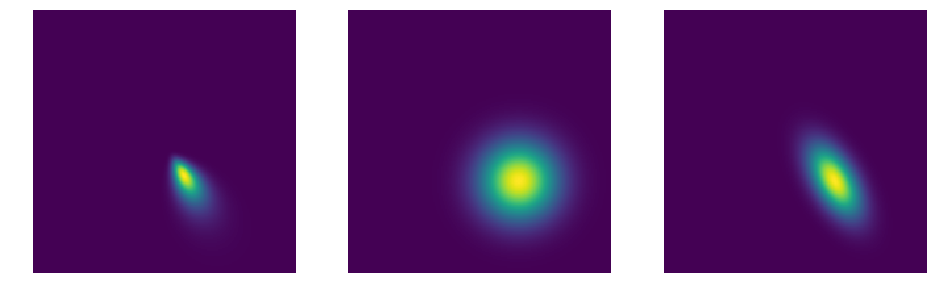

In [249]:
f, ss = plt.subplots(1,3,figsize=(16,6))
ss[0].imshow(gauss2D_logpolar(ecc, polar, mu=(1.5, np.pi/3), sigma=0.38, kappa=30))
ss[0].axis('off')
ss[1].imshow(gauss2D_iso_cart(x, y, mu=(1.5, 1.5), sigma=1.0))
ss[1].axis('off')
ss[2].imshow(gauss2D_rot_cart(x, y, mu=(1.5, 1.5), sigma=1.0, theta=np.pi/3, ar=2.0))
ss[2].axis('off')

In [171]:
np.log(np.e)

1.0

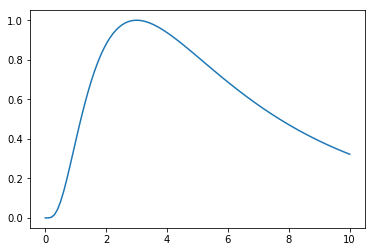

In [214]:
plt.plot(np.linspace(0,10, 100), gauss1D_log(np.linspace(0,10, 100), 3, 0.8))